In [219]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [220]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
sector = pd.read_csv('sectors_walmart.csv', index_col='PID')
data = data.merge(sector[['Sector','DfromWalmart']], on='PID')
data.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Pav

## Look at <span style="color:darkred">Sales Prices</span> 💵

In [221]:
y = data.SalePrice.copy()

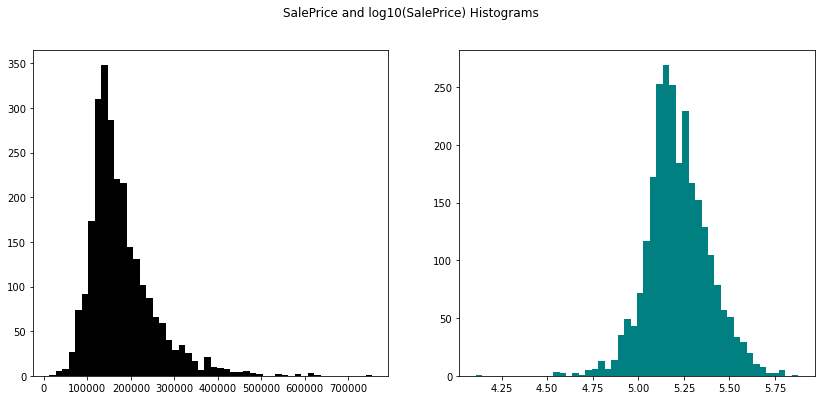

In [222]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('SalePrice and log10(SalePrice) Histograms')

ax1.hist(y, bins=50,color='k');
ax2.hist(np.log10(y), bins=50, color='teal');

## <span style="color:darkred">Land-based</span> features ⛰️
* MSZoning / LotArea / LotShape / LandContour / Utilities / LandSlope / Condition1 / Condition2 / Sector

In [223]:
landfeats = data[['MSZoning','LotArea','LotShape','LandContour','Utilities',
                  'LandSlope','Condition1','Condition2','Neighborhood','Sector']].copy()

**Numeric Features:** LotArea

In [224]:
landfeats.LotArea.describe()

count      2579.000000
mean      10119.269484
std        8128.389882
min        1300.000000
25%        7406.500000
50%        9382.000000
75%       11485.500000
max      215245.000000
Name: LotArea, dtype: float64

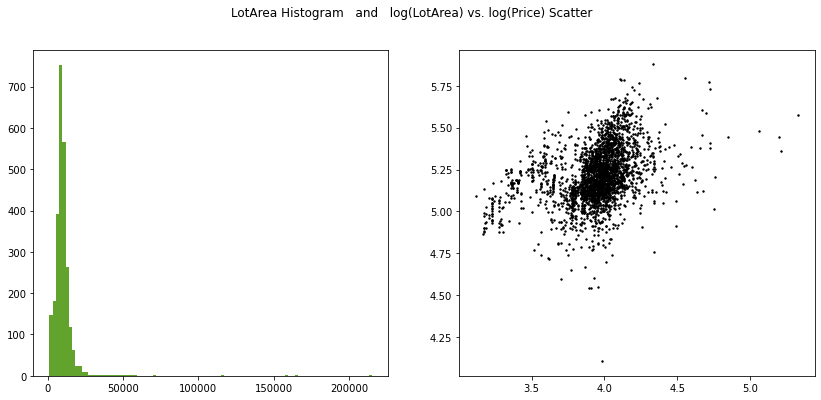

In [225]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('LotArea Histogram   and   log(LotArea) vs. log(Price) Scatter')

ax1.hist(landfeats.LotArea, bins=100)
ax2.scatter(x=np.log10(landfeats.LotArea),y=np.log10(y),s=2,c='k')

**Categorical Features:** MSZoning / LotShape / LandContour / Utilities / LandSlope / Condition1 / Condition2 / Sector

In [226]:
for col in landfeats.drop('LotArea', axis=1).columns:
    print(landfeats[col].value_counts())
    print('---------------------------')

RL         2007
RM          418
FV          113
RH           21
C (all)      17
I (all)       2
A (agr)       1
Name: MSZoning, dtype: int64
---------------------------
Reg    1640
IR1     855
IR2      71
IR3      13
Name: LotShape, dtype: int64
---------------------------
Lvl    2337
Bnk      95
HLS      95
Low      52
Name: LandContour, dtype: int64
---------------------------
AllPub    2577
NoSewr       2
Name: Utilities, dtype: int64
---------------------------
Gtl    2458
Mod     108
Sev      13
Name: LandSlope, dtype: int64
---------------------------
Norm      2227
Feedr      137
Artery      81
RRAn        40
PosN        37
RRAe        26
PosA        19
RRNn         8
RRNe         4
Name: Condition1, dtype: int64
---------------------------
Norm      2554
Feedr       12
PosA         3
Artery       3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64
---------------------------
NAmes      410
CollgCr    236
OldTown    213
Edwards    165
Som

In [227]:
land_all = y.to_frame().merge(landfeats, on='PID')

In [228]:
land_all['MSZoning'].value_counts().index

Index(['RL', 'RM', 'FV', 'RH', 'C (all)', 'I (all)', 'A (agr)'], dtype='object')

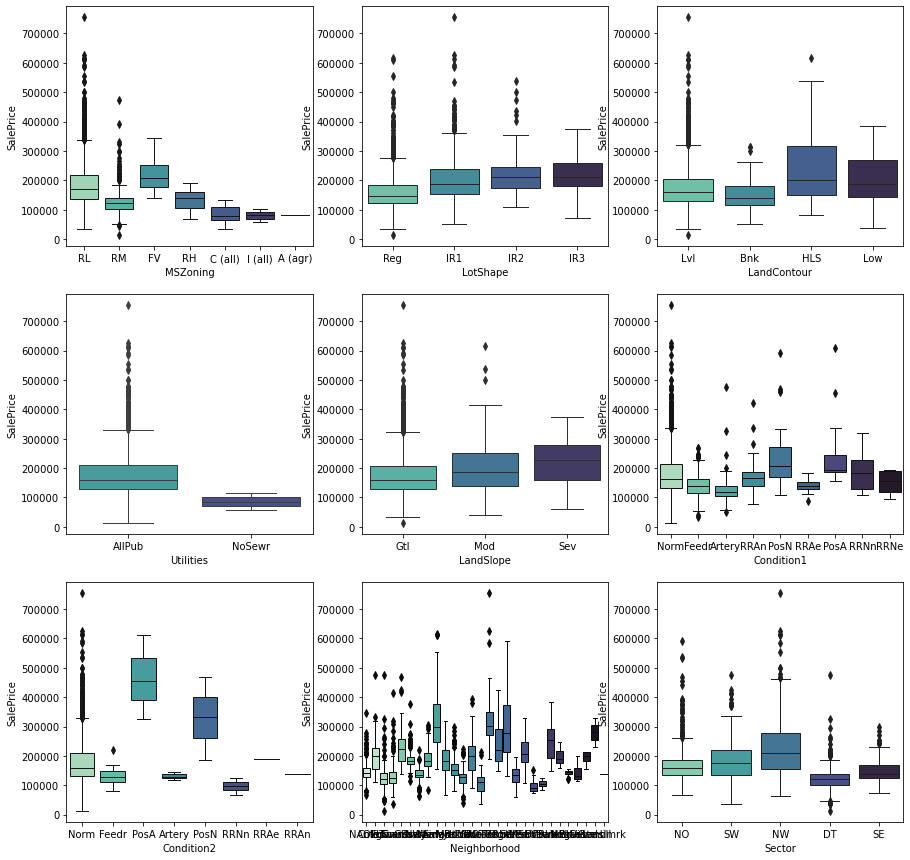

In [229]:
fig, ax = plt.subplots(3,3, figsize=(15,15))

for idx, COL in enumerate(landfeats.drop('LotArea', axis=1).columns):
    sns.boxplot(ax=ax[idx//3,idx%3],
            x=land_all[COL], y=land_all['SalePrice'], 
            order = land_all[COL].value_counts().index,
            palette="mako_r", linewidth=1)

### Findings
* LotShape and LandContour and LandSlope: may not be useful. Similar SalePrice, and concentrated in 1-2 categories
* Utilities: only 2 houses have 'No Sewer', rest are same
* Condition1 & Condition2: may be useful if a house is of PosN or PosA category, otherwise, not much use.

## <span style="color:darkred">General House</span> Features 📐
* MasVnrType, MasVnrArea, BldgType, HouseStyle, YearBuilt, YearRemodAdd, OverallQual, OverallCond

In [230]:
general = data[['MSSubClass','MasVnrType', 'MasVnrArea', 'BldgType', 
                'HouseStyle', 'YearBuilt', 'YearRemodAdd', 
                'OverallQual', 'OverallCond']]

In [231]:
general.head(3)

,MSSubClass,MasVnrType,MasVnrArea,BldgType,HouseStyle,YearBuilt,YearRemodAdd,OverallQual,OverallCond
PID,,,,,,,,,
526301100,20,Stone,112.0,1Fam,1Story,1960,1960,6,5
526302030,20,Stone,28.0,1Fam,1Story,1954,1954,6,5
526302040,20,BrkFace,244.0,1Fam,1Story,1956,1956,6,6


In [232]:
#Check Missing
general.isna().sum(axis=0)

MSSubClass       0
MasVnrType      14
MasVnrArea      14
BldgType         0
HouseStyle       0
YearBuilt        0
YearRemodAdd     0
OverallQual      0
OverallCond      0
dtype: int64

In [233]:
#Fill with "None" and 0
general = general.fillna({'MasVnrType':'None', 'MasVnrArea':0})
general.MasVnrType.isna().sum() + general.MasVnrArea.isna().sum()

0

In [234]:
np.round(general.MSSubClass.value_counts(normalize=True).sort_index()*100,2)

20     36.41
30      4.77
40      0.23
45      0.66
50     10.00
60     19.46
70      4.50
75      0.81
80      4.23
85      1.67
90      3.37
120     6.55
150     0.04
160     4.65
180     0.58
190     2.06
Name: MSSubClass, dtype: float64

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

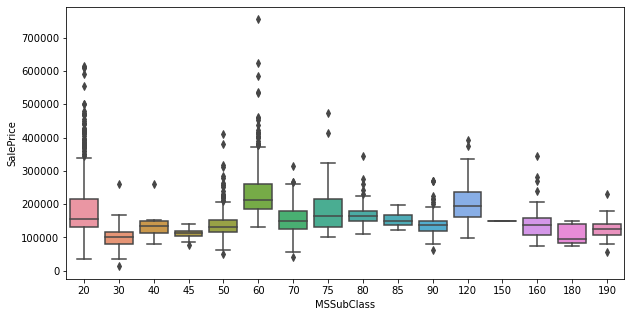

In [235]:
#Plot HouseClass
plt.figure(figsize=(10,5))
sns.boxplot(x=general.MSSubClass, y=y)

####  MSSubClass: Type of dwelling
        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

#### Convert to:
    1Fl = 20,30,40,45,50
    2Fl = 60,70,75
    SPLIT = 80,85
    PUD1Fl = 120,150
    PUD2Fl = 160,180
    DUP2FAM = 90,190

In [236]:
conv_dict = {}
for k in [20,30,40,45,50]:
    conv_dict[k] = '1FL'
for k in [60,70,75]:
    conv_dict[k] = '2FL'
for k in [80,85]:
    conv_dict[k] = 'SPLIT'
for k in [120,150]:
    conv_dict[k] = 'PUD1Fl'
for k in [160,180]:
    conv_dict[k] = 'PUD2Fl'
for k in [90,190]:
    conv_dict[k] = 'DUP2FAM'

general.loc[:,'MSSubClass'] = general.loc[:,'MSSubClass'].apply(lambda r: conv_dict[r])

In [237]:
general.MSSubClass.value_counts().sort_index()

1FL        1343
2FL         639
DUP2FAM     140
PUD1Fl      170
PUD2Fl      135
SPLIT       152
Name: MSSubClass, dtype: int64

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

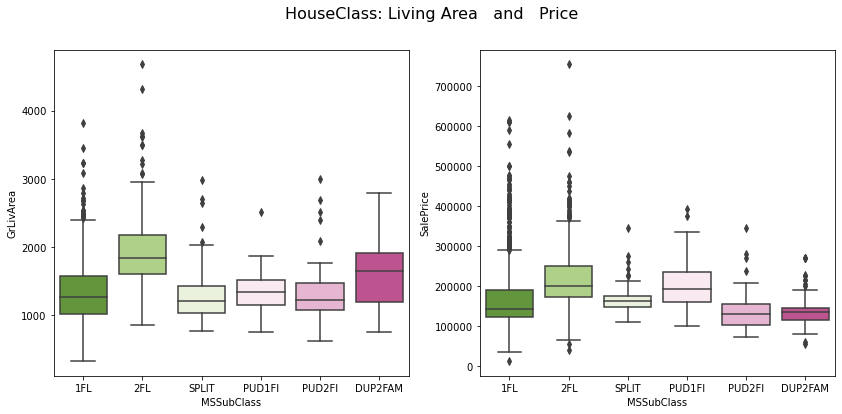

In [238]:
#Plot NEW HouseClass
sns.set_palette('PiYG_r')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('HouseClass: Living Area   and   Price', size=16)

sns.boxplot(ax=ax1,x=general.MSSubClass, y=data.GrLivArea)
sns.boxplot(ax=ax2,x=general.MSSubClass, y=y)

## <span style="color:red">Findings</span>: 2Fl PUD, Duplexes, and 2Fam conversions are priced low (esp. relative to their size)

In [239]:
general = general.join(data[['Sector','Neighborhood','SalePrice']],on='PID')

In [272]:
# percentage of houseClass in each Sector of city
temp = general.groupby(['Sector'])['MSSubClass'].value_counts(normalize=True).to_frame()
temp.rename(columns={'MSSubClass':'HouseType'}, inplace=True)
temp.reset_index(inplace=True)
temp = temp.pivot(index='MSSubClass',columns='Sector', values='HouseType')
temp

Sector,DT,NO,NW,SE,SW
MSSubClass,,,,,
1FL,0.666667,0.504414,0.413681,0.384058,0.583463
2FL,0.234097,0.234552,0.311075,0.079710,0.248050
DUP2FAM,0.089059,0.049180,0.035831,0.079710,0.051482
PUD1Fl,NaN,0.073140,0.117264,0.072464,0.046802
PUD2Fl,0.002545,0.055485,0.070033,0.217391,0.026521
SPLIT,0.007634,0.083228,0.052117,0.166667,0.043682


Text(0, 0.5, 'Proportion')

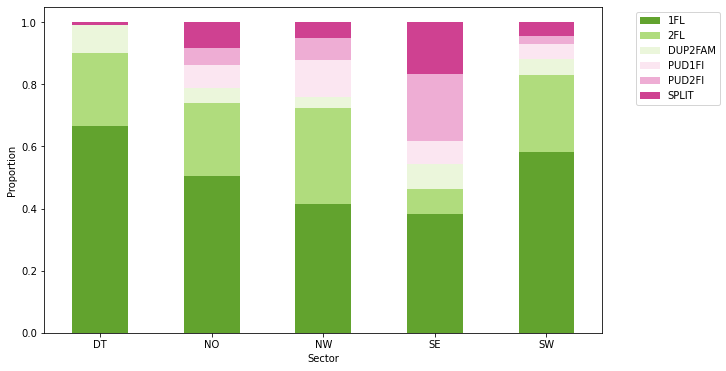

In [289]:
fig, ax1 = plt.subplots()
temp.T.plot(ax=ax1, kind='bar', rot=0, stacked=True, figsize=(10,6)).legend(bbox_to_anchor=(1.051, 1.0));
ax1.set_ylabel('Proportion')

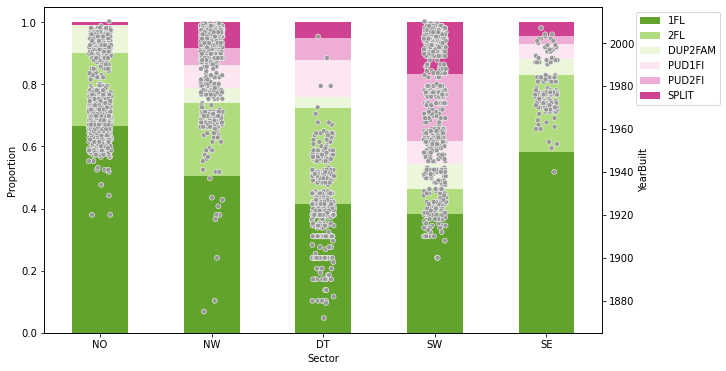

In [315]:
fig, ax1 = plt.subplots()
temp.T.plot(ax=ax1, kind='bar', rot=0, stacked=True, figsize=(10,6)).legend(bbox_to_anchor=(1.051, 1.0));
ax1.set_ylabel('Proportion')
ax2 = ax1.twinx()
sns.stripplot(ax=ax2, x='Sector', y='YearBuilt', data=general, color='0.6', edgecolor='w', linewidth=0.5);

In [268]:
temp = general.groupby(['Sector','MSSubClass']).agg('median')[['YearBuilt','SalePrice']]
temp.reset_index(inplace=True)
temp = temp.pivot(index='MSSubClass',columns='Sector', values=['YearBuilt','SalePrice'])
temp

YearBuilt                                 SalePrice            \
Sector            DT      NO      NW      SE      SW        DT        NO   
MSSubClass                                                                 
1FL           1928.5  1960.0  1995.0  1982.0  1966.0  115750.0  145000.0   
2FL           1914.0  1996.0  1998.0  1993.0  1997.0  140375.0  187500.0   
DUP2FAM       1920.0  1962.0  1977.0  1976.0  1953.0  119600.0  135000.0   
PUD1Fl           NaN  2000.0  2004.0  1996.5  2003.0       NaN  189500.0   
PUD2Fl        1993.0  1973.0  2000.0  1972.0  2004.0  137000.0  114850.0   
SPLIT         1963.0  1967.0  1976.5  1977.0  1977.0  126000.0  168250.0   

                                          
Sector            NW        SE        SW  
MSSubClass                                
1FL         186000.0  143000.0  162250.0  
2FL         260116.0  188000.0  204000.0  
DUP2FAM     143476.5  146500.0  135900.0  
PUD1Fl      206500.0  146750.0  152600.0  
PUD2Fl      170000.0   87000.0  134000.0  
SPLIT       154750.0  153500.0  162500.0

## <span style="color:red">Findings</span>: DT House prices being low is mainly due to the AGE of the houses
### But why are SE houses so cheap?

In [16]:
#Check Categorical counts
for COL in general.drop(['MasVnrArea','YearBuilt','YearRemodAdd'],axis=1).columns:
    print(general[COL].value_counts())

None       1572
BrkFace     804
Stone       183
BrkCmn       20
Name: MasVnrType, dtype: int64
1Fam      2138
TwnhsE     202
Twnhs       98
Duplex      87
2fmCon      54
Name: BldgType, dtype: int64
1Story    1288
2Story     773
1.5Fin     283
SLvl       118
SFoyer      70
2.5Unf      22
1.5Unf      19
2.5Fin       6
Name: HouseStyle, dtype: int64
5     752
6     669
7     525
8     290
4     195
9      80
3      32
10     20
2      13
1       3
Name: OverallQual, dtype: int64
5    1402
6     497
7     360
8     140
4      88
9      41
3      39
2       8
1       4
Name: OverallCond, dtype: int64


Plot Numerical Features with SalePrice

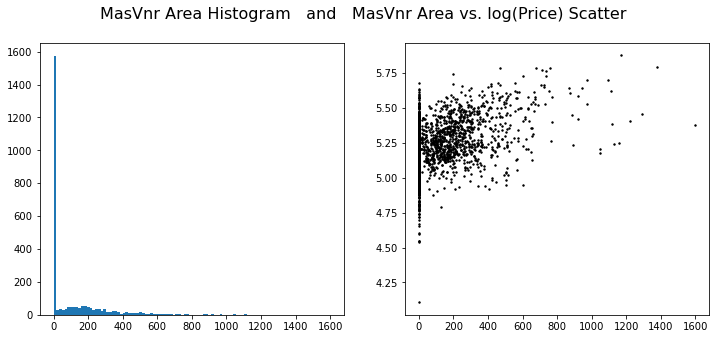

In [235]:
#Plot MasVnrArea
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('MasVnr Area Histogram   and   MasVnr Area vs. log(Price) Scatter', size=16)

ax1.hist(general.MasVnrArea, bins=100)
ax2.scatter(x=general.MasVnrArea,y=np.log10(y),s=2,c='k')

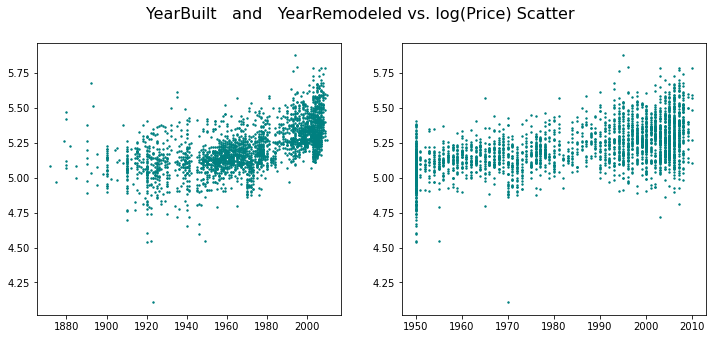

In [236]:
#Plot Year Built
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('YearBuilt   and   YearRemodeled vs. log(Price) Scatter', size=16)

ax1.scatter(x=general.YearBuilt,y=np.log10(y),s=2,c='teal')
ax2.scatter(x=general.YearRemodAdd,y=np.log10(y),s=2,c='teal')

In [237]:
# Simple Linear Regression
from sklearn.linear_model import LinearRegression

In [238]:
lm = LinearRegression()
lm.fit(general[['YearBuilt','YearRemodAdd']],y)
lm.score(general[['YearBuilt','YearRemodAdd']],y)

0.35793128073777514

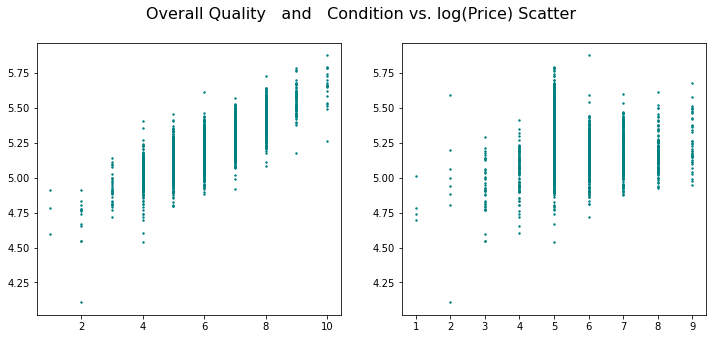

In [239]:
#Plot Quality and Condition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('Overall Quality   and   Condition vs. log(Price) Scatter', size=16)

ax1.scatter(x=general.OverallQual,y=np.log10(y),s=2,c='teal')
ax2.scatter(x=general.OverallCond,y=np.log10(y),s=2,c='teal')

In [240]:
lm = LinearRegression()
lm.fit(general[['OverallQual','OverallCond']],y)
lm.score(general[['OverallQual','OverallCond']],y)

0.6257934465721093

In [241]:
lm = LinearRegression()
lm.fit(general[['OverallQual']],y)
lm.score(general[['OverallQual']],y)

0.6251450369427116

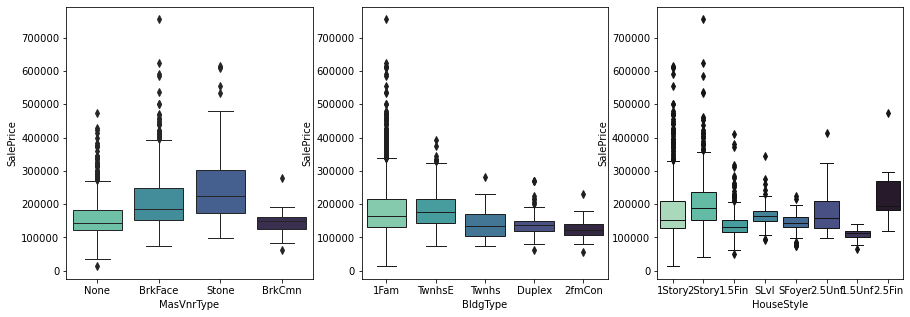

In [242]:
# Plot MasVnrTYPE, BldgType, HouseStyle, 
fig, ax = plt.subplots(1,3, figsize=(15,5))

for idx, COL in enumerate(['MasVnrType', 'BldgType', 'HouseStyle']):
    sns.boxplot(ax=ax[idx],
            x=general[COL], y=y, 
            order = general[COL].value_counts().index,
            palette="mako_r", linewidth=1)

## <span style="color:darkred">Size Related</span> Features 📐
* Columns with "SF" / "AREA" / "Porch Size"

In [243]:
size_related = data.filter(regex='SF$|Area$|(Porch)')
size_related.isnull().sum(axis=0)

GrLivArea         0
LotArea           0
MasVnrArea       14
BsmtUnfSF         1
TotalBsmtSF       1
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GarageArea        1
WoodDeckSF        0
OpenPorchSF       0
EnclosedPorch     0
3SsnPorch         0
ScreenPorch       0
PoolArea          0
dtype: int64

In [1]:
size_related = size_related.fillna(0.0)  # We fill the very minor missing values by 0.0

NameError: name 'size_related' is not defined

### Create new Feature called <span style="color:blue">PorchArea</span> (Sum of all Porch & Deck)
* WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

In [245]:
size_related['PorchArea'] = size_related[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

In [246]:
#Drop unnecessary columns
size_related.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)

<AxesSubplot:>

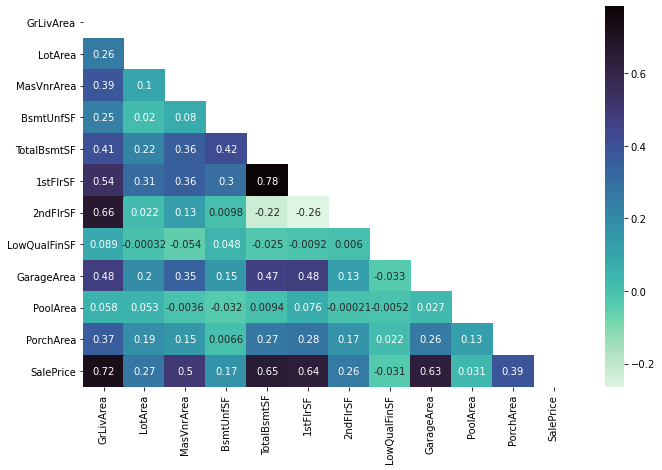

In [247]:
corr = pd.concat([size_related, y], axis=1).corr()

# Hide upper redundant heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(corr, mask=mask, annot=True, cmap='mako_r')

### Investigate GrLivArea (largest correlation with Sale Price 0.72)

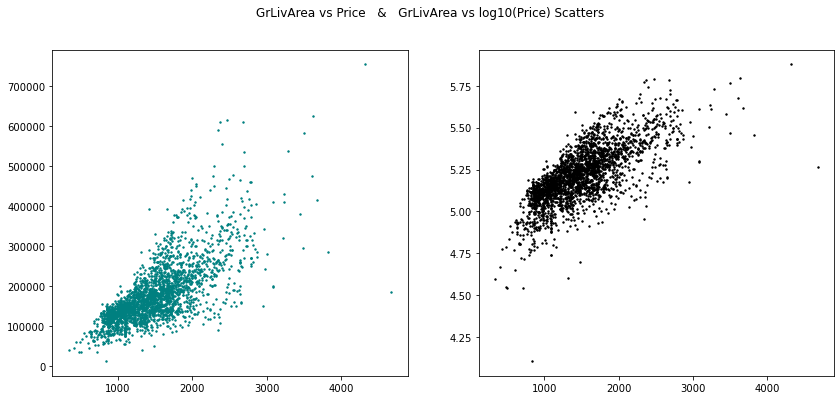

In [248]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('GrLivArea vs Price   &   GrLivArea vs log10(Price) Scatters')

ax1.scatter(x=size_related.GrLivArea,y=y,s=2,c='teal')
ax2.scatter(x=size_related.GrLivArea,y=np.log10(y),s=2,c='k')

In [249]:
lm = LinearRegression()
lm.fit(np.log10(size_related[['GrLivArea']]),np.log10(y))
print(f"R2: {lm.score(np.log10(size_related[['GrLivArea']]),np.log10(y))}")
print(f'B1: {lm.coef_}')

R2: 0.5400663903547829
B1: [0.88111154]


#### Check Scatterplot for others

In [250]:
size_related.columns

Index(['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'PoolArea',
       'PorchArea'],
      dtype='object')

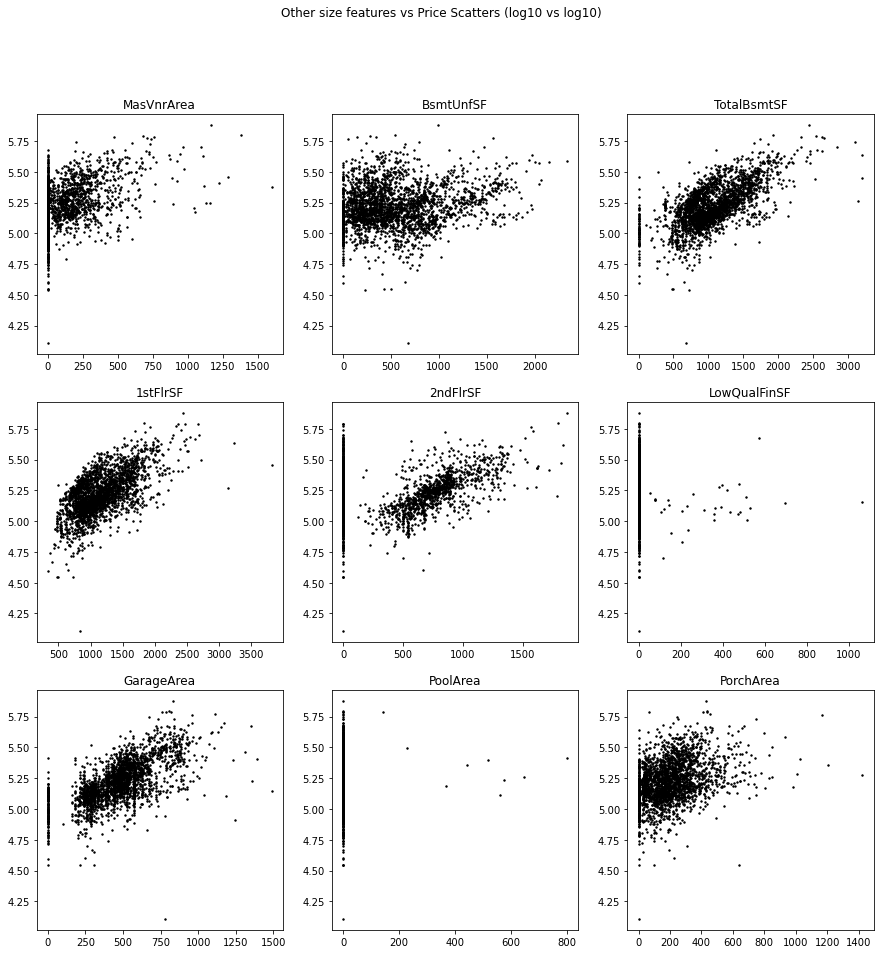

In [251]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Other size features vs Price Scatters (log10 vs log10)')

for idx, COL in enumerate(size_related.drop(['GrLivArea','LotArea'],axis=1).columns):
    ax[idx//3,idx%3].scatter(x=size_related[COL],y=np.log10(y), s=2,c='k')
    ax[idx//3,idx%3].set_title(str(COL))

#### <span style="color:blue">1stFlr, Bsmt, 2ndFlr, Garage</span> might be useful

### Create new Feature called <span style="color:blue">LBratio</span> (Land to Building Ratio)
* LotArea / 1stFlrSF

In [252]:
size_related['LBratio'] = size_related.LotArea/size_related['1stFlrSF']

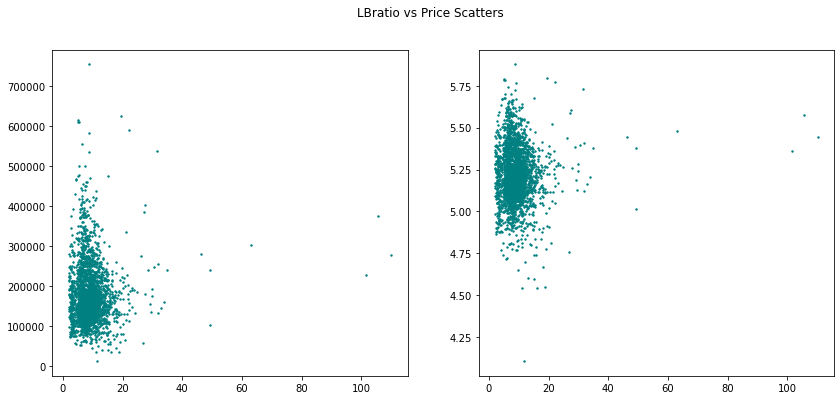

In [253]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('LBratio vs Price Scatters')

ax1.scatter(x=size_related.LBratio,y=y,s=2,c='teal')
ax2.scatter(x=size_related.LBratio,y=np.log10(y),s=2,c='teal')

#### 💩 <span style="color:red">WORTHLESS</span>, get rid of it

In [254]:
size_related.drop('LBratio',axis=1, inplace=True)

### Basement info not yet utilized, create feature called <span style="color:blue">BsmtFinRatio</span> (Ratio of Finished Basement)
* (TotalBsmtSF - BsmtUnfSF) / TotalBsmtSF

In [283]:
size_related['BsmtFinRatio'] = (size_related.TotalBsmtSF - size_related.BsmtUnfSF)/size_related.TotalBsmtSF

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


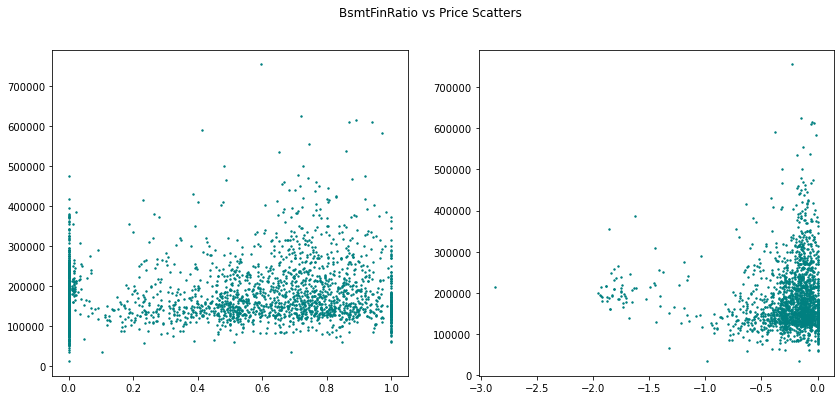

In [284]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('BsmtFinRatio vs Price Scatters')

ax1.scatter(x=size_related.BsmtFinRatio,y=y,s=2,c='teal')
ax2.scatter(x=np.log10(size_related.BsmtFinRatio),y=y,s=2,c='teal')

#### 💩 <span style="color:red">WORTHLESS</span>, get rid of it

In [268]:
size_related.drop('BsmtFinRatio',axis=1, inplace=True)